## Member of Team

Raka Julianza Hernanda
2402313171

Syauqi Damario Djohan
2502478616

Najmi Hasfi Abiyyu
2502478622

## Library Model

### Machine Learning

In [1]:
import fitz
import re
import pandas as pd
import numpy as np

from string import digits
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

### Model Deep Learning

In [2]:
import tensorflow as tf
import transformers

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import TFBertModel
from transformers import AutoTokenizer, AutoModel, BertTokenizer

from tokenizers import BertWordPieceTokenizer

# model_choice = "distilbert-base-multilingual-cased"
model_choice = "bert-base-uncased"

2024-11-03 07:36:09.388652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 07:36:09.515923: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 07:36:09.553157: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 07:36:11.793268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Load Dataset

In [3]:
df = pd.read_csv('Metadata_Real.csv', sep=';')
df

,keyword,amar,amar_lainnya,name_document,result_text
0,NaN,Ditolak,—,zaef6125c5c7d37caf65313530303333,menolak permohonan kasasi dari pemohon kasasi ...
1,NaN,Ditolak,—,zaef6125473ccd00a6b3313435373030,menolak permohonan kasasi dari pemohon kasasi ...
2,kekhilafan hakim atau kekeliruan,Ditolak,—,zaef6124fcbd259093f1313435343535,menolak permohonan peninjauan kembali dari pem...
3,kekhilafan Hakim atau kekeliruan,Diterima,—,zaef6123d8b0a16494bf313434363435,kembali menyatakan terpidana ilhamsyah alias a...
4,NaN,Ditolak,—,zaef53b89bf9a1088ca8313235363232,menolak permohonan kasasi dari pemohon kasasi ...
...,...,...,...,...,...
163,NARKOTIKA,Ditolak,M E N G A D I L I:- Menolak permohonan kasasi ...,zaeedd3cedc9a87285e5313831333435,menolak permohonan kasasi dari pemohon kasasi ...
164,NARKOTIKA,Diterima,TOLAK PK,b221ff0c27190fadd1849b0217cb026f,menolak permohonan peninjauan kembali dari pem...
165,NaN,Ditolak,—,c80f8c7108c24c0c41ad4c3a7604a667,menolak permohonan peninjauan kembali dari pem...
166,Kesehatan,Diterima,PIDANA PENJARA WAKTU TERTENTU,zaef678698ededb6bf5d313734383436,dari putusan nomor disclaimer kepaniteraan mah...


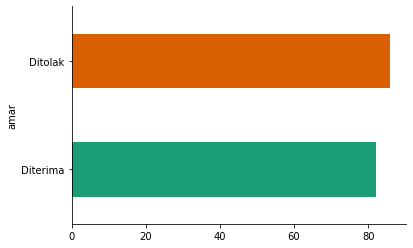

In [4]:
df.groupby('amar').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Preprocessing

### Label Encoder

In [5]:
label_encoder = preprocessing.LabelEncoder()
df['amar']= label_encoder.fit_transform(df['amar']) 

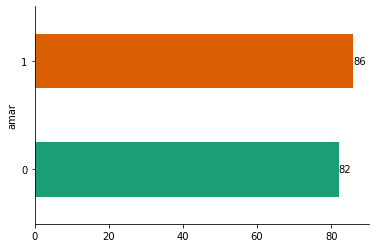

In [6]:
df.groupby('amar').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
for index, value in enumerate(df.groupby('amar').size()):
    plt.text(value, index, str(value), va='center')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Split Data

In [7]:
train, valid = train_test_split(df, test_size=0.3, random_state=42)

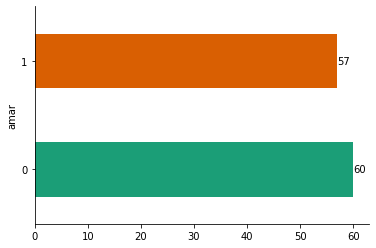

In [8]:
# Train
train.groupby('amar').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
for index, value in enumerate(train.groupby('amar').size()):
    plt.text(value, index, str(value), va='center')
plt.gca().spines[['top', 'right',]].set_visible(False)

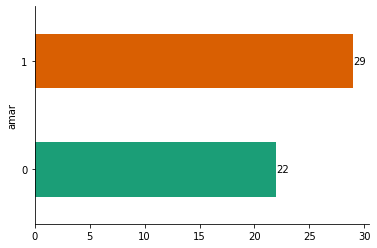

In [9]:
# Valid
valid.groupby('amar').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
for index, value in enumerate(valid.groupby('amar').size()):
    plt.text(value, index, str(value), va='center')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Config Preprocessing

In [10]:
chunk_size = 256
maxlen = 512

### Tokenizer

In [11]:
def fast_encode(texts, tokenizer, chunk_size=chunk_size, maxlen=maxlen):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    all_masks = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
        all_masks.extend([enc.attention_mask for enc in encs])  # Add attention masks
    
    return np.array(all_ids), np.array(all_masks)

In [12]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(model_choice)
tokenizer.save_pretrained('.')
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)

/home/cdsw/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


In [13]:
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [14]:
x_train_ids, x_train_masks = fast_encode(train.result_text.astype(str), fast_tokenizer, maxlen=maxlen)
x_valid_ids, x_valid_masks = fast_encode(valid.result_text.astype(str), fast_tokenizer, maxlen=maxlen)

y_train = train.amar
y_valid = valid.amar

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 307.68it/s]


## Model

### Config Model

In [15]:
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 15
BATCH_SIZE = 16
MAX_LEN = 512
n_steps = 64

shuffle = 1024

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'tun_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'
)

num_labels = 2

In [16]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(((x_train_ids, x_train_masks), y_train))
    .repeat()
    .shuffle(shuffle)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices(((x_valid_ids, x_valid_masks), y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

2024-11-03 07:36:23.716601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 07:36:23.830303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:2f:00.0, compute capability: 7.0


### Modelling

In [17]:
def build_model(transformer, max_len=MAX_LEN, num_labels=num_labels):
    input_word_ids = Input(shape=(MAX_LEN), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(MAX_LEN), dtype=tf.int32, name="attention_mask")
    sequence_output = transformer([input_word_ids, attention_mask])[0]
    
    cls_token = sequence_output[:, 0, :]
    out = Dense(num_labels, activation='softmax')(cls_token)
    
    model = Model(inputs=[input_word_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
%%time
transformer_layer = TFBertModel.from_pretrained(model_choice)
model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

/home/cdsw/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializ

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [19]:
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[model_checkpoint]
)

Epoch 1/15
64/64 [==============================] - 66s 803ms/step - loss: 0.6410 - accuracy: 0.6250 - val_loss: 0.6057 - val_accuracy: 0.6471
Epoch 2/15
64/64 [==============================] - 46s 727ms/step - loss: 0.3208 - accuracy: 0.8652 - val_loss: 0.8439 - val_accuracy: 0.7255
Epoch 3/15
64/64 [==============================] - 47s 736ms/step - loss: 0.1093 - accuracy: 0.9561 - val_loss: 1.3125 - val_accuracy: 0.7647
Epoch 4/15
64/64 [==============================] - 41s 643ms/step - loss: 0.0251 - accuracy: 0.9912 - val_loss: 1.4274 - val_accuracy: 0.7451
Epoch 5/15
64/64 [==============================] - 41s 641ms/step - loss: 0.0125 - accuracy: 0.9951 - val_loss: 1.7273 - val_accuracy: 0.7059
Epoch 6/15
64/64 [==============================] - 41s 641ms/step - loss: 0.0179 - accuracy: 0.9932 - val_loss: 1.6597 - val_accuracy: 0.7647
Epoch 7/15
64/64 [==============================] - 47s 733ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.5475 - val_accuracy: 0.8235

In [20]:
valid_history = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=5
)

Epoch 1/5
64/64 [==============================] - 33s 506ms/step - loss: 0.2633 - accuracy: 0.9326
Epoch 2/5
64/64 [==============================] - 33s 507ms/step - loss: 0.0157 - accuracy: 0.9939
Epoch 3/5
64/64 [==============================] - 33s 506ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 4/5
64/64 [==============================] - 33s 506ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 5/5
64/64 [==============================] - 33s 506ms/step - loss: 6.7247e-04 - accuracy: 1.0000


## Summary

### Result

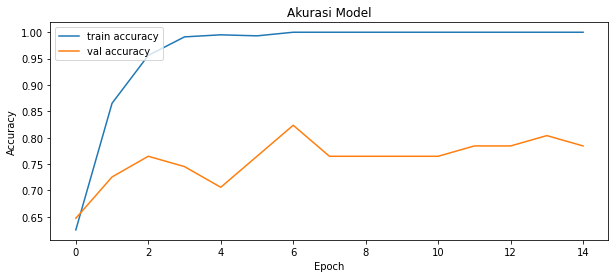

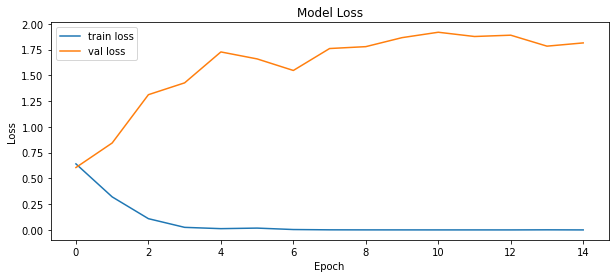

In [21]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(train_history.history['accuracy'], label = 'train accuracy')
ax.plot(train_history.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Akurasi Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(train_history.history['loss'], label = 'train loss')
ax.plot(train_history.history['val_loss'], label = 'val loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc = 'upper left')
plt.show()

In [32]:
result = model.evaluate(valid_dataset)
result

4/4 [==============================] - 1s 156ms/step - loss: 4.3995e-05 - accuracy: 1.0000


[4.3995427404297516e-05, 1.0]

In [33]:
print(f"Resnet Model Accuracy Train: {result[1] * 100: 0.2f} %")

Resnet Model Accuracy Train:  100.00 %


### Confusion Matrix & Classification Report

In [24]:
y_pred = model.predict((x_valid_ids, x_valid_masks))

2/2 [==============================] - 3s 244ms/step


In [25]:
y_pred = y_pred.argmax(axis=1)
y_pred

array([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1])

In [26]:
cm = confusion_matrix(y_valid, y_pred)
print(cm)

[[22  0]
 [ 0 29]]


In [27]:
cr = classification_report(y_valid, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        29

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



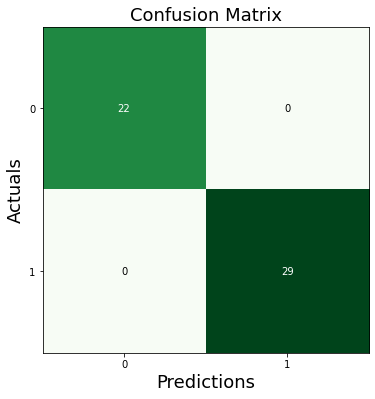

In [28]:
conf_matrix = confusion_matrix(y_valid, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()